# Sharpen Your Sharpe Ratio Analysis

By Simon Ellersgaard Nielsen

In 'The Statistics of the Sharpe Ratio' A. Lo famously established confidence intervals for the Sharpe ratio under the assumption of i.i.d. normal returns. See https://alo.mit.edu/wp-content/uploads/2017/06/The-Statistics-of-Sharpe-Ratios.pdf .

In 'Comparing Sharpe Ratios: So Where are the p-Values?' J. Dyke went a step further and established confidence intervals for the difference between Sharpe ratios, thereby facilitating a rigorous analysis of the claim that one trading strategy is superior to another. See https://papers.ssrn.com/sol3/papers.cfm?abstract_id=886728 .

While these are admirable theoretical advances, it is often as simple (and empirically more robust) to bootstrap one's way to the relevant confidence intervals. This is precisely what I set out to do here.

## Load Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Generate Correlated Returns Series 

Suppose we have two series with the following properties:

In [3]:
N = 1000     # Observations
mu1 = 0.05   # Mean return of series 1
sig1 = 0.25  # Vol of series 1
mu2 = 0.06   # Mean return of series 2
sig2 = 0.25  # Vol of series 2
rho = 0.75   # Correlation between return series 

We assume two geometric Brownian motions. We generate these using a Cholesky decomposition:

In [4]:
def generate_series():

    X1 = np.array(np.random.normal(0,1,N))
    X2 = np.array(np.random.normal(0,1,N))
    
    W1 = mu1 + sig1*X1
    W2 = mu2 + sig2*(rho*X1 + np.sqrt(1-pow(rho,2))*X2)
    pnl = pd.DataFrame(np.array([W1,W2]).T,columns=['pnl1','pnl2'])
    pnl['cum1'] = pnl['pnl1'].cumsum()
    pnl['cum2'] = pnl['pnl2'].cumsum()
    
    return pnl

pnl = generate_series()

To make sure we have done the right thing, let's compute the sample parameters and plot the return series:

Mean 1   : 0.050 true vs. 0.063 estimated
Std 1    : 0.250 true vs. 0.248 estimated
Sharpe 1 : 3.175 true vs. 4.039 estimated
Mean 2   : 0.060 true vs. 0.073 estimated
Std 2    : 0.250 true vs. 0.248 estimated
Sharpe 2 : 3.810 true vs. 4.658 estimated
Correl   : 0.750 true vs. 0.753 estimated


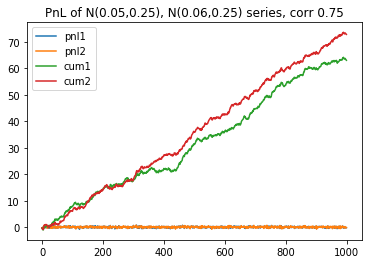

In [5]:
def compute_and_plot(pnl):
    
    emp_mean = pnl[['pnl1','pnl2']].mean(axis=0)
    emp_std = pnl[['pnl1','pnl2']].std(axis=0)
    emp_shrp = np.sqrt(252.0)*emp_mean/emp_std
    emp_corr = pnl[['pnl1','pnl2']].corr(method='pearson').iloc[0,1]
    
    print("=========================================")
    print("Mean 1   : {:.3f} true vs. {:.3f} estimated".format(mu1,emp_mean.loc['pnl1']))
    print("Std 1    : {:.3f} true vs. {:.3f} estimated".format(sig1,emp_std.loc['pnl1']))
    print("Sharpe 1 : {:.3f} true vs. {:.3f} estimated".format(np.sqrt(252.0)*mu1/sig1,emp_shrp.loc['pnl1']))
    print("=========================================")
    print("Mean 2   : {:.3f} true vs. {:.3f} estimated".format(mu2,emp_mean.loc['pnl2']))
    print("Std 2    : {:.3f} true vs. {:.3f} estimated".format(sig2,emp_std.loc['pnl2']))
    print("Sharpe 2 : {:.3f} true vs. {:.3f} estimated".format(np.sqrt(252.0)*mu2/sig2,emp_shrp.loc['pnl2']))
    print("=========================================")
    print("Correl   : {:.3f} true vs. {:.3f} estimated".format(rho,emp_corr))
    print("=========================================")
    
    pnl.plot(title='PnL of N({:.2f},{:.2f}), N({:.2f},{:.2f}) series, corr {:.2f}'.format(mu1,sig1,mu2,sig2,rho))
    
compute_and_plot(pnl)    

This looks plausible. Notice that the vol estimates are better than the mean estimates. This shouldn't be surprising. The mean estimate is essentially a telescoping sum on the asset price level (meaning that only the first and last entry feature in the computation). Indeed, the standard error of the mean is of $O(\sigma^2)$, whereas the standard error on the (squared) vol is $O(2*\sigma^4)$.

## The Bootstrap

Next, we will bootstrap our way to the sample parameters. I.e. we will sample the return series (with replacement) repeatedly and compute the parameters of interest. 
These parameters are the sample Sharpe ratio of series 1, the sample Sharpe ratio of series 2, and the difference between their sample Sharpe ratios.

In [7]:
def bootstrap(pnl,MC=1000):

    """
    pnl is a dataframe with two correlated return series
    MC is the number of times we sample
    
    In each sample we compute mu, sigma, and Sharpe for each of the two series.
    We also compute the difference in Sharpe ratios
    """
    
    
    Nl = pnl.shape[0]
    
    Q = []
    for m in np.arange(MC):
            
        subset = pnl.sample(n=Nl,replace=True)
        mu_m = subset.mean()
        sig_m = subset.std()
    
        row_m = [mu_m.pnl1,
                 sig_m.pnl1,   
                 np.sqrt(252.0)*mu_m.pnl1/sig_m.pnl1,
                 mu_m.pnl2,  
                 sig_m.pnl2,
                 np.sqrt(252.0)*mu_m.pnl2/sig_m.pnl2,
                 np.sqrt(252.0)*mu_m.pnl2/sig_m.pnl2-np.sqrt(252.0)*mu_m.pnl1/sig_m.pnl1]
        
        Q.append(row_m)
        #data.iloc[m] = row_m
        
    lbl = ['mu1','sig1','shp1','mu2','sig2','shp2','dshp']    
    data = pd.DataFrame(Q,index=np.arange(MC),columns=lbl)    

    return data

data = bootstrap(pnl)  

Let's display the sample distributions, both in a table and in histograms.

           mean          SE        Z
mu1   0.0629056  0.00767222  8.19914
sig1   0.247676  0.00522196  47.4297
shp1    4.03371    0.499986  8.06765
mu2   0.0727402  0.00797396  9.12222
sig2   0.248029  0.00533857  46.4599
shp2    4.65796     0.52196  8.92398
dshp   0.624253    0.362563  1.72178


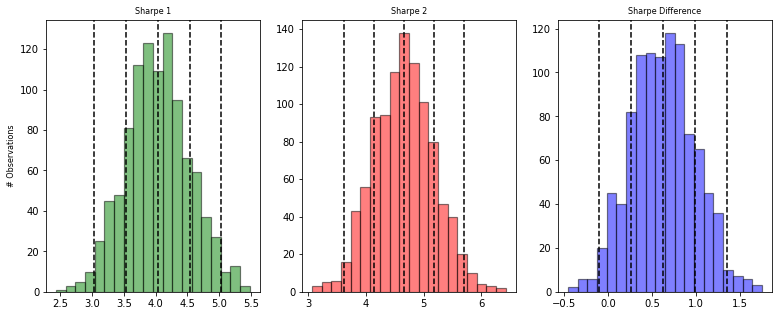

In [8]:
def verticals(summ,ax,i,lbl):
    
    ax[i].axvline(summ.at['mean',lbl],color='k',linestyle='--')
    ax[i].axvline(summ.at['mean',lbl]-summ.at['SE',lbl],color='k',linestyle='--')
    ax[i].axvline(summ.at['mean',lbl]-2*summ.at['SE',lbl],color='k',linestyle='--')
    ax[i].axvline(summ.at['mean',lbl]+summ.at['SE',lbl],color='k',linestyle='--')
    ax[i].axvline(summ.at['mean',lbl]+2*summ.at['SE',lbl],color='k',linestyle='--')

def bootstrap_plot(data):
    
    means = data.mean()
    lbl = data.columns
    MC = data.shape[0]
    
    summ = pd.DataFrame(None,index=['mean','SE','Z'],columns=lbl)
    for l in lbl:
        
        vm = means[l]
        vset = np.array(data[l].values)
        summ.at['mean',l] = vm
        summ.at['SE',l] = np.sqrt(np.dot(vset-vm,vset-vm)/(MC-1))
        summ.at['Z',l] = summ.at['mean',l]/summ.at['SE',l]
        
    print(summ.T)
    
    ################################
    
    fig, ax = plt.subplots(1,3)
    ax[0].hist(data['shp1'],bins=20,facecolor='green',edgecolor='black', linewidth=1.2, alpha=0.5)
    ax[1].hist(data['shp2'],bins=20,facecolor='red',edgecolor='black', linewidth=1.2, alpha=0.5)
    ax[2].hist(data['dshp'],bins=20,facecolor='blue',edgecolor='black', linewidth=1.2, alpha=0.5)
    ax[0].set_title('Sharpe 1',fontsize=8)
    ax[0].set_ylabel('# Observations',fontsize=8)
    ax[1].set_title('Sharpe 2',fontsize=8)
    ax[2].set_title('Sharpe Difference',fontsize=8)
    verticals(summ,ax,0,'shp1')
    verticals(summ,ax,1,'shp2')
    verticals(summ,ax,2,'dshp')
    
    fig.set_size_inches(13,5)
    
bootstrap_plot(data)    

## Conclusion

The estimated Sharpe ratios cover the population paramaters. Indeed we strongly reject the null hypothesis that the Sharpe ratios are zero. Although the second (population) Sharpe ratio is larger than the first (population) Sharpe ratio, we fail to reject the null hypothesis that they are equal when we do the sampling.